In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from sklearn.preprocessing import normalize

Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = data_per_word * len(words)
timesteps = 50
dimensions = 3 * 44

In [3]:
def get_bone_pos(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    bone_pos = np.zeros([44, 3]) # [cooridinates x fingers]
#     finger_tip = {}
    if 'right' in frame['hands']:
        bone_pos[0, :] = np.array([frame['hands']['right']['yaw'], frame['hands']['right']['roll'], frame['hands']['right']['pitch']])
        bone_pos[1, :] = np.array(frame['hands']['right']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[2 + 5 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[2 + 10 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[2 + 15 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['metacarpal']['next_joint'])
    if 'left' in frame['hands']:
        bone_pos[22, :] = np.array([frame['hands']['left']['yaw'], frame['hands']['left']['roll'], frame['hands']['left']['pitch']])
        bone_pos[23, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[4 + 20 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[4 + 25 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[4 + 30 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[4 + 35 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['metacarpal']['next_joint'])

    return bone_pos

In [4]:
import json
import pandas as pd
import numpy as np

In [5]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.array([])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        pick_frame_every_no = len(json_data) / 50 + 1
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            bones_pos = get_bone_pos(frame)
            for idx, bone_pos in enumerate(bones_pos):
                x[word_no * data_per_word + data_no, curr_idx, idx * 3: idx * 3 + 3] = bone_pos
            curr_idx += 1

        y = np.append(y, word_no)

In [6]:
x_min = x.min(axis=(0,1), keepdims=True)
x_max = x.max(axis=(0,1), keepdims=True)
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [10]:
x_train = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 / 3])
x_test = np.zeros([data_length / 3, timesteps, dimensions])
y_test = np.zeros([data_length / 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx / 3] = x_norm[idx]
        y_test[idx / 3] = y[idx]
    else:
        x_train[idx - idx / 3] = x_norm[idx]
        y_train[idx - idx / 3] = y[idx]

In [11]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 / 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [12]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [13]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=500, batch_size=8, shuffle=True)

Train on 342 samples, validate on 171 samples
Epoch 1/500
342/342 [==============================] - 4s 11ms/step - loss: 2.9939 - acc: 0.0497 - val_loss: 2.8103 - val_acc: 0.0877
Epoch 2/500
342/342 [==============================] - 2s 6ms/step - loss: 2.7580 - acc: 0.1316 - val_loss: 2.4235 - val_acc: 0.1930
Epoch 3/500
342/342 [==============================] - 2s 6ms/step - loss: 2.5691 - acc: 0.1520 - val_loss: 2.5634 - val_acc: 0.1637
Epoch 4/500
342/342 [==============================] - 2s 6ms/step - loss: 2.4824 - acc: 0.1316 - val_loss: 2.2565 - val_acc: 0.1930
Epoch 5/500
342/342 [==============================] - 2s 6ms/step - loss: 2.3705 - acc: 0.2018 - val_loss: 2.2888 - val_acc: 0.1813
Epoch 6/500
342/342 [==============================] - 2s 6ms/step - loss: 2.3280 - acc: 0.1579 - val_loss: 2.3239 - val_acc: 0.1754
Epoch 7/500
342/342 [==============================] - 2s 6ms/step - loss: 2.3691 - acc: 0.1754 - val_loss: 2.0879 - val_acc: 0.2573
Epoch 8/500
342/342 [=

Epoch 62/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3062 - acc: 0.4678 - val_loss: 1.6144 - val_acc: 0.5322
Epoch 63/500
342/342 [==============================] - 2s 6ms/step - loss: 1.4859 - acc: 0.4298 - val_loss: 1.6783 - val_acc: 0.4971
Epoch 64/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3625 - acc: 0.4415 - val_loss: 1.5014 - val_acc: 0.5673
Epoch 65/500
342/342 [==============================] - 2s 6ms/step - loss: 1.2835 - acc: 0.4883 - val_loss: 1.4687 - val_acc: 0.5263
Epoch 66/500
342/342 [==============================] - 2s 6ms/step - loss: 1.2999 - acc: 0.4854 - val_loss: 1.6142 - val_acc: 0.5029
Epoch 67/500
342/342 [==============================] - 2s 6ms/step - loss: 1.3100 - acc: 0.4942 - val_loss: 1.5951 - val_acc: 0.4971
Epoch 68/500
342/342 [==============================] - 2s 6ms/step - loss: 1.2556 - acc: 0.5058 - val_loss: 1.5634 - val_acc: 0.5146
Epoch 69/500
342/342 [==============================] - 2s 6ms

Epoch 123/500
342/342 [==============================] - 2s 6ms/step - loss: 0.9205 - acc: 0.6667 - val_loss: 1.2986 - val_acc: 0.6082
Epoch 124/500
342/342 [==============================] - 2s 6ms/step - loss: 1.0112 - acc: 0.5906 - val_loss: 1.4960 - val_acc: 0.5614
Epoch 125/500
342/342 [==============================] - 2s 6ms/step - loss: 0.9188 - acc: 0.6462 - val_loss: 1.3478 - val_acc: 0.6082
Epoch 126/500
342/342 [==============================] - 2s 6ms/step - loss: 0.9682 - acc: 0.6345 - val_loss: 1.3473 - val_acc: 0.5906
Epoch 127/500
342/342 [==============================] - 2s 6ms/step - loss: 0.8997 - acc: 0.6754 - val_loss: 1.4172 - val_acc: 0.5789
Epoch 128/500
342/342 [==============================] - 2s 6ms/step - loss: 0.9837 - acc: 0.6404 - val_loss: 1.2773 - val_acc: 0.6199
Epoch 129/500
342/342 [==============================] - 2s 6ms/step - loss: 0.9490 - acc: 0.6228 - val_loss: 1.2928 - val_acc: 0.5906
Epoch 130/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 0.8593 - acc: 0.6491 - val_loss: 1.4231 - val_acc: 0.6608
Epoch 184/500
342/342 [==============================] - 2s 6ms/step - loss: 0.7828 - acc: 0.6754 - val_loss: 1.5097 - val_acc: 0.6550
Epoch 185/500
342/342 [==============================] - 2s 6ms/step - loss: 0.8225 - acc: 0.6491 - val_loss: 1.3928 - val_acc: 0.6550
Epoch 186/500
342/342 [==============================] - 2s 6ms/step - loss: 0.7947 - acc: 0.6696 - val_loss: 1.4306 - val_acc: 0.6784
Epoch 187/500
342/342 [==============================] - 2s 6ms/step - loss: 0.8004 - acc: 0.6930 - val_loss: 1.5111 - val_acc: 0.6550
Epoch 188/500
342/342 [==============================] - 2s 6ms/step - loss: 0.8670 - acc: 0.6988 - val_loss: 1.4321 - val_acc: 0.6784
Epoch 189/500
342/342 [==============================] - 2s 6ms/step - loss: 0.9144 - acc: 0.6754 - val_loss: 1.4666 - val_acc: 0.6901
Epoch 190/500
342/342 [==============================] - 2s 6ms/step 

Epoch 244/500
342/342 [==============================] - 2s 6ms/step - loss: 0.6306 - acc: 0.7573 - val_loss: 1.3833 - val_acc: 0.6959
Epoch 245/500
342/342 [==============================] - 3s 8ms/step - loss: 0.6585 - acc: 0.7310 - val_loss: 1.4197 - val_acc: 0.6901
Epoch 246/500
342/342 [==============================] - 3s 9ms/step - loss: 0.6473 - acc: 0.7544 - val_loss: 1.3861 - val_acc: 0.6725
Epoch 247/500
342/342 [==============================] - 2s 7ms/step - loss: 0.7066 - acc: 0.7281 - val_loss: 1.4608 - val_acc: 0.6842
Epoch 248/500
342/342 [==============================] - 3s 10ms/step - loss: 0.6338 - acc: 0.7719 - val_loss: 1.5191 - val_acc: 0.6784
Epoch 249/500
342/342 [==============================] - 3s 10ms/step - loss: 0.5826 - acc: 0.7602 - val_loss: 1.5544 - val_acc: 0.6959
Epoch 250/500
342/342 [==============================] - 3s 8ms/step - loss: 0.6429 - acc: 0.7573 - val_loss: 1.4800 - val_acc: 0.6784
Epoch 251/500
342/342 [==============================

342/342 [==============================] - 2s 6ms/step - loss: 0.5487 - acc: 0.7544 - val_loss: 1.3434 - val_acc: 0.7193
Epoch 305/500
342/342 [==============================] - 2s 7ms/step - loss: 0.5498 - acc: 0.7778 - val_loss: 1.3406 - val_acc: 0.7368
Epoch 306/500
342/342 [==============================] - 2s 7ms/step - loss: 0.6194 - acc: 0.7807 - val_loss: 1.3860 - val_acc: 0.7076
Epoch 307/500
342/342 [==============================] - 2s 6ms/step - loss: 0.6699 - acc: 0.7281 - val_loss: 1.4389 - val_acc: 0.7135
Epoch 308/500
342/342 [==============================] - 2s 6ms/step - loss: 0.6606 - acc: 0.7632 - val_loss: 1.4586 - val_acc: 0.7018
Epoch 309/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5644 - acc: 0.7836 - val_loss: 1.4051 - val_acc: 0.7485
Epoch 310/500
342/342 [==============================] - 2s 7ms/step - loss: 0.5511 - acc: 0.7778 - val_loss: 1.3577 - val_acc: 0.7310
Epoch 311/500
342/342 [==============================] - 2s 6ms/step 

Epoch 365/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5644 - acc: 0.7924 - val_loss: 1.4612 - val_acc: 0.7193
Epoch 366/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5450 - acc: 0.7778 - val_loss: 1.5190 - val_acc: 0.7193
Epoch 367/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4930 - acc: 0.7924 - val_loss: 1.5101 - val_acc: 0.7251
Epoch 368/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5807 - acc: 0.7719 - val_loss: 1.4838 - val_acc: 0.7368
Epoch 369/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5801 - acc: 0.7924 - val_loss: 1.4470 - val_acc: 0.7368
Epoch 370/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4544 - acc: 0.8158 - val_loss: 1.5553 - val_acc: 0.7310
Epoch 371/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4980 - acc: 0.7895 - val_loss: 1.5513 - val_acc: 0.7427
Epoch 372/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 0.4409 - acc: 0.8246 - val_loss: 1.4328 - val_acc: 0.7661
Epoch 426/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5231 - acc: 0.7953 - val_loss: 1.4543 - val_acc: 0.7544
Epoch 427/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5656 - acc: 0.8099 - val_loss: 1.3668 - val_acc: 0.7544
Epoch 428/500
342/342 [==============================] - 2s 6ms/step - loss: 0.5365 - acc: 0.8246 - val_loss: 1.3407 - val_acc: 0.7368
Epoch 429/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4870 - acc: 0.8304 - val_loss: 1.3237 - val_acc: 0.7485
Epoch 430/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4661 - acc: 0.8099 - val_loss: 1.3032 - val_acc: 0.7485
Epoch 431/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4478 - acc: 0.8216 - val_loss: 1.3806 - val_acc: 0.7427
Epoch 432/500
342/342 [==============================] - 2s 6ms/step 

Epoch 486/500
342/342 [==============================] - 2s 6ms/step - loss: 0.3731 - acc: 0.8421 - val_loss: 1.3839 - val_acc: 0.7661
Epoch 487/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4614 - acc: 0.8392 - val_loss: 1.4681 - val_acc: 0.7719
Epoch 488/500
342/342 [==============================] - 2s 6ms/step - loss: 0.4377 - acc: 0.8216 - val_loss: 1.4922 - val_acc: 0.7251
Epoch 489/500
342/342 [==============================] - 2s 7ms/step - loss: 0.4065 - acc: 0.8538 - val_loss: 1.5244 - val_acc: 0.7193
Epoch 490/500
342/342 [==============================] - 2s 7ms/step - loss: 0.4865 - acc: 0.8275 - val_loss: 1.4582 - val_acc: 0.7427
Epoch 491/500
342/342 [==============================] - 2s 7ms/step - loss: 0.4923 - acc: 0.8158 - val_loss: 1.4325 - val_acc: 0.7485
Epoch 492/500
342/342 [==============================] - 2s 7ms/step - loss: 0.4718 - acc: 0.8246 - val_loss: 1.4253 - val_acc: 0.7485
Epoch 493/500
342/342 [==============================] 

In [15]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 643us/step
('Test score:', 1.3445026318580784)
('Test accuracy:', 0.7251462005732352)


In [16]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


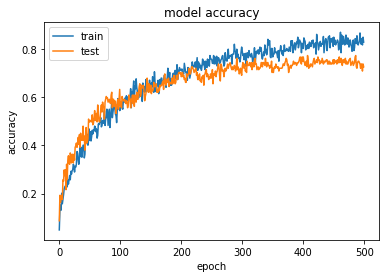

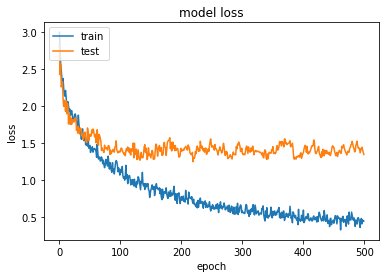

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()